In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh

from matplotlib import cm

""" import the Tilings package... """
import sys
sys.path.insert(0, '../../gaps_topology/Tilings') # prepend the path to the Tiling package
import Tilings as tl
import SKK_approximants as skk

%matplotlib inline 

"""
Styling
See: http://matplotlib.org/users/customizing.html

TeX rendering:
You can use TeX to render all of your matplotlib text if the rc
parameter text.usetex is set.  This works currently on the agg and ps
backends, and requires that you have tex and the other dependencies
described at http://matplotlib.org/users/usetex.html
properly installed on your system.  The first time you run a script
you will see a lot of output from tex and associated tools.  The next
time, the run may be silent, as a lot of the information is cached in
~/.tex.cache
"""
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern'], 'size':16})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
# colors
BostonBlue = np.array([0., 104., 139.])/255
comp = np.array([200., 35., 0.])/255
# linewidth of plots
rc('lines', lw = 2)
# fontsize of the labels
rc('axes', labelsize = 16)
# bbox='tight' tries to make the bounding box fit the plot area
# pad_inches is the distance between the bounding box and the plot area
# see http://matplotlib.org/users/tight_layout_guide.html
rc('savefig', bbox = 'tight', pad_inches = .1)

# Geometry

In [2]:
"""
Construct Pavel's approximant
"""
ninfl = 7

# construct the elementary triangle
e = np.identity(4)
orig = np.zeros(4)
ea = e[0]
eb = e[2]
B = orig
A = orig + ea
C = orig + ea + eb
t1 = [(1, (A, B, C))]
# create the approximant
approx = tl.A5(t1)
# inflate it
approx.it_sub(ninfl)
# set up the edges
skk.affect_order(approx, ninfl)
# retrieve the graph
graph = approx._graph
# projection matrices useful later
para = approx.para()
perp = approx.perp_proj()

In [3]:
"""
Compute the height field
"""
# compute the height field
wg = approx.integrate_arrow_field((0,0,0,0))
height = nx.get_node_attributes(wg, 'weight')
# height field: h(p2) - h(p1) = (-1)**(ninfl+1) * 2
h12 = (2*(ninfl % 2) - 1)*2

# add the height data to the graph
nx.set_node_attributes(graph, "height", height)
# reflect the SKK domain to obtain a bigger and more regularly spaced system
reflgraph = approx.reflect(graph, 1)

# Groundstate computation & plots

In [4]:
"""
Import or compute the groundstate
"""
# construct the Hamiltonians
V = 0.
Honsite, Hhop = skk.symmetric_hams(graph)
H = V*Honsite + Hhop
# compute the groundstate in the symmetric representation
En, gs = eigsh(H, k=1, which = "SA")
gs = np.abs(gs.flatten())
# go to the real representation
gs = skk.torealspace(graph, gs)
# compute the coordinates of the apexes of the triangle
Mi = np.linalg.matrix_power(approx._M, ninfl) # inflation matrix
p10 = np.zeros(4)
p20 = np.array([1,0,1,0])
p1 = tuple(np.dot(Mi, p10))
p2 = tuple(np.dot(Mi, p20))

# associate to each node the corresponding groundstate wavefunction component
wf = dict(zip(graph.nodes(), gs))
# measure beta
beta = (wf[p2]/wf[p1])**(1./h12)
print("lambda = ", 1./beta**2.)
# remove the lambda part, only keeping the cake part
cake = [wf[p]*beta**(-height[p]) for p in graph]

lambda =  1.35808037643


In [5]:
"""
Add groundstate (and other) data to the graph
"""
# affect to each site its type (according to first neighbors environment)
siteType = {3:'F', 4:'E', 6:'C', 7:'B', 8:'A'}
index = dict(zip(graph.nodes(), range(len(graph))))
for p in graph:
    neighs = graph[p]
    # the Honsite ham gives the right coordinence
    idx = index[p]
    z = Honsite[idx, idx]
    if z in siteType.keys():
        graph.node[p]['type'] = siteType[z]
    else:
        graph.node[p]['type'] = 'D1'
        if 3 in [Honsite[index[n], index[n]] for n in neighs]:
            graph.node[p]['type'] = 'D2'
# add the cake data to the graph
nx.set_node_attributes(graph, "cake", dict(zip(graph.nodes(), cake)))
# add the exponential factor data to the graph
nx.set_node_attributes(graph, "exponential", {p:beta**height[p] for p in graph})
# add the height data to the graph
nx.set_node_attributes(graph, "height", height)
# reflect the SKK domain to obtain a bigger and more regularly spaced system
reflgraph = approx.reflect(graph, 1)

In [16]:
"""
Plot the graph over a region
"""

def subgraph(graph, in_region):
    """
    Return the subgraph containing the nodes in a given region in physical space.
    """
    selected_nodes = [p for p in graph if in_region(graph.node[p]['para'])]
    return nx.subgraph(graph, selected_nodes)

L = 4.5
r0 = np.array([5., 1.])
def in_region(r):
    """
    True is point r is in the region.
    """
    return r0[0] <= r[0] <= r0[0] + L and r0[1] <= r[1] <= r0[1] + L

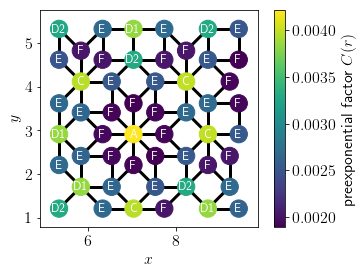

In [17]:
"""
Plot with networkx (suited for small graphs, because edges are visible)
"""
# select a small subgraph to plot (the previous cell has to be run first)
ugraph = subgraph(graph, in_region)
# which projection to use (para or perp)
proj = 'para'
# which part of the wf to plot (exponential or cake)
term = 'cake'
# retrive position
pos = nx.get_node_attributes(ugraph, proj)
# color the nodes according to the type of data we want
node_color = [ugraph.node[p][term] for p in ugraph]

s = 300.
nx.draw_networkx(ugraph, pos, with_labels=True, labels=nx.get_node_attributes(ugraph, 'type'),
                 font_color='w', node_size=s, width=3, node_color=node_color)

# set up the colorbar
sm = plt.cm.ScalarMappable()
sm.set_array(node_color)
cb = plt.colorbar(sm)#,  ticks=[0.1, 0.12])
# title of the colorbar
if term == 'cake':
    cb.ax.set_ylabel(r'preexponential factor $C(r)$')
else:
    cb.ax.set_ylabel(r'exponential factor $\exp(\kappa h(r))$')
# custom ticks for the colorbar
#cb.ax.set_yticklabels(['Low', 'Medium'])
# axes labels
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.axes().set_aspect('equal')
plt.savefig("../img3/SKK_subgraph_" + term + "_" + str(ninfl) + "_" + proj + ".svg", alpha = 1., dpi=300)

In [8]:
def o(n):
    a, b = 0, 1
    for i in range(n):
        a, b = b, a + 2*b
    return a

def norm(n):
    return np.sqrt(8.*o(n)**2+2.*(-1)**n)

def proj_graph(graph, proj, orig):
    """ 
    Create a graoh copy with the projection onto perp space added as node data.
    """
    pg = graph
    for p in graph.nodes():
        pp = np.dot(proj, p)
        pg.node[p]['proj'] = pp - orig
        
    return pg

ei = lambda i: (-1)**((i) // 4)*e[(i)%4]

def boundary_graph(n, proj, ninfl):
    """
    Create a graph whose boundaries delimit the nth coordination zones in perp space.
    Rk: I have no idea of what happens if n > 1.
    """
    n += 1
    g = nx.grid_graph([n,n,n,n])
    # add edges to mark the boundary between D1 and D2 regions
    p0 = np.zeros(4)
    for i in range(8):
        # link a site (p0) of the inner octagon to the next (p1), going counterclockwise
        p1 = p0 + np.sum(ei(3*i+j) for j in range(3))
        # add the corresponding edge to the graph: this edge is the boundary between a D1 and a D2 domain.
        g.add_edge(tuple(p0), tuple(p1))
        p0 = p1
    p = np.array([-o(ninfl),-o(ninfl+1)])/norm(ninfl)
    orig = np.dot(proj, [0,0,1,0]) - p
    pg = proj_graph(g, proj, orig)
    return pg

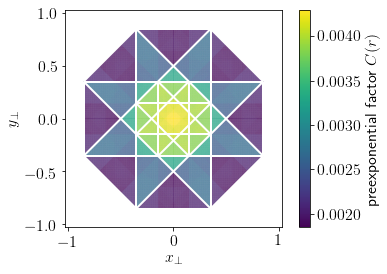

In [9]:
"""
Plot with plt.scatter (do not plot the edges, suited for large approximants)
"""

# which projection to use (para or perp)
proj = 'perp'
# which part of the wf to plot (exponential or cake)
term = 'cake'
# color the nodes according to the type of data we want
node_color = [reflgraph.node[p][term] for p in reflgraph]
# create a boundary graph
if proj == 'perp':
    pmat = approx.perp_proj()
else:
    pmat = approx.para()
bg = boundary_graph(1, pmat, ninfl)

s = .15
# retrive position
pos = nx.get_node_attributes(reflgraph, proj)
x, y = np.transpose([pos[p] for p in reflgraph])
plt.scatter(x, y, s=s, c=node_color, edgecolor='', cmap="viridis", alpha=1.)
# plot the boundaries if there is a boundary graph
if bg:
    dict_pos = nx.get_node_attributes(bg, 'proj')
    plt.axes().set_aspect('equal')
    nx.draw_networkx(bg, dict_pos, with_labels = False, node_size= 0, edge_color = 'w', width = 2.)        

# set up the colorbar
cb = plt.colorbar()#,  ticks=[0.1, 0.12])
# title of the colorbar
if term == 'cake':
    cb.ax.set_ylabel(r'preexponential factor $C(r)$')
else:
    cb.ax.set_ylabel(r'exponential factor $\exp(\kappa h(r))$')
# custom ticks for the colorbar
#cb.ax.set_yticklabels(['Low', 'Medium'])
# axes labels
plt.xlabel(r"$x_\perp$")
plt.ylabel(r"$y_\perp$")
plt.axes().set_aspect('equal')
plt.savefig("../img3/SKK_" + term + "_" + str(ninfl) + "_" + proj + ".png", dpi=400, alpha=1.)

# Slice
Run the gometry section before running this one.

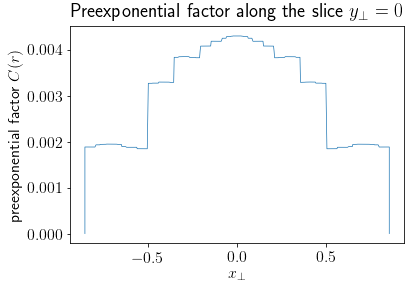

In [14]:
"""
Compute and plot the slice in one direction
"""

# which slice to plot (the slice will be made out of the points whose y coord verifies y = min {y|y>=yslice})
yslice = 0.
# which projection to use (para or perp)
proj = 'perp'
# which part of the wf to plot (exponential, cake, or height)
term = 'cake'
# color the nodes according to the type of data we want
node_color = [reflgraph.node[p][term] for p in reflgraph]

# retrive position
pos = nx.get_node_attributes(reflgraph, proj)
# keep only the positions
ppos = np.transpose([pos[p] for p in reflgraph])
# rotate by pi/4 if perp
# if proj == 'perp':
ppos = np.array([ppos[0]+ppos[1], ppos[0]-ppos[1]])/np.sqrt(2)

X, Y = ppos
Z = node_color

#X = np.around(X, 5)
# round so that all pts belonging to the same slice have the same y coordinate
Y = np.around(Y, 5)
# find the coordinate y0 of the slice we want to plot
y0 = np.max(Y)
for y in Y:
    if y >= yslice and y < y0:
        y0 = y
# select all the points belonging to the slice
Xslice = []
Zslice = []
for x, y, z in zip(X, Y, Z):
    if y == y0:
        Xslice.append(x)
        Zslice.append(z)
# sort XX by ascending order
Xslice, Zslice = zip(*sorted(zip(Xslice, Zslice)))
Xslice = list(Xslice)
Zslice = list(Zslice)
# add points at both extremeties
Xslice.insert(0,np.min(Xslice))
Xslice.append(np.max(Xslice))
Zslice.insert(0,0)
Zslice.append(0)
# plot!
plt.plot(Xslice, Zslice, '-', ms=1., linewidth=0.7)
if proj == 'perp':
    plt.xlabel(r"$x_\perp$")
else:
    plt.xlabel(r"$x(i)$")
if term == 'cake':
    plt.ylabel(r'preexponential factor $C(r)$')
    plt.title(r"Preexponential factor along the slice $y_\perp = 0$")
elif term == 'exponential':
    plt.ylabel(r'exponential factor $\exp(\kappa h(r))$')
    plt.title(r'Exponential factor along the slice $ y = $' + str(y0))
else:
    plt.ylabel(r'Height $h(i)$')
    plt.title(r'Height along the slice $x(i) = y(i)$')
plt.savefig("SKK_" + term + "_slice_" + str(ninfl) + "_" + proj + ".svg", dpi=400)

# Highligth lines

In [11]:
"""
Plot the graph over a region
"""

def subgraph(graph, in_region):
    """
    Return the subgraph containing the nodes in a given region in physical space.
    """
    selected_nodes = [p for p in graph if in_region(graph.node[p]['para'])]
    return nx.subgraph(graph, selected_nodes)

L = 8.5
r0 = np.array([0., 0.])
def in_region(r):
    """
    True is point r is in the region.
    """
    return r0[0] <= r[0] <= r0[0] + L and r0[1] <= r[1] <= r0[1] + L

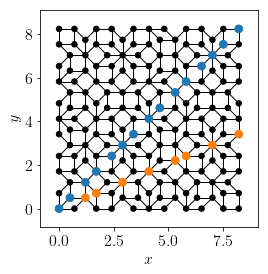

In [12]:
"""
Plot with networkx (suited for small graphs, because edges are visible)
"""
# select a small subgraph to plot (the previous cell has to be run first)
ugraph = subgraph(reflgraph, in_region)
# which projection to use (para or perp)
proj = 'para'
# retrive position
pos = nx.get_node_attributes(ugraph, proj)
# color the nodes according to the type of data we want
e = np.eye(4)
ep3 = np.dot(approx.para(), e[3])
i = 5
ep8 = np.array([np.cos(i*np.pi/8), np.sin(i*np.pi/8)])
node_color = []
s = []
# matplotlib default colors (get them with plt.rcParams['axes.prop_cycle'])
blue = '#1f77b4'
yellow = '#ff7f0e'
# size of selected points 
S = 60.
# size of other points
sd = 30.
for p in pos:
    para = pos[p]
    if np.isclose(np.dot(para, ep3), 0):
        node_color.append(blue)
        s.append(S)
    elif np.isclose(np.dot(para, ep8), 0):
        node_color.append(yellow)
        s.append(S)
    else:
        node_color.append('black')
        s.append(sd)

# s = 10.
nx.draw_networkx(ugraph, pos, with_labels=False,
                 node_size=s, width=1, node_color=node_color)

# axes labels
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.axes().set_aspect('equal')
plt.savefig("SKK_subgraph_highlight_" + str(ninfl) + "_" + proj + ".pdf", alpha = 1., dpi=300)